In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest_date = dt.datetime.strptime(session.query(func.max(Measurement.date)).first()[0], "%Y-%m-%d")
last_year_date = latest_date - dt.timedelta(days = 365)

In [10]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).\
          filter(Measurement.date > last_year_date).all()

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns = ["Date", "Precipitation"]).set_index("Date")

# Drop rows have a NaN value
prcp_df = prcp_df.dropna()

prcp_df.head()

,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


In [12]:
# Sort the dataframe by date
prcp_df = prcp_df.sort_index()
prcp_df.head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,1.22


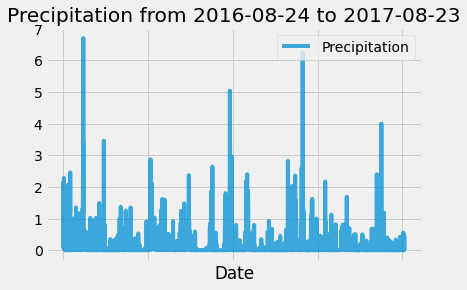

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(alpha = 0.75)

# Remove x tick labels
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False
)
plt.title(f"Precipitation from {min(prcp_df.index)} to {max(prcp_df.index)}")
plt.xlabel("Date")
plt.legend(loc = 1)

plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
available_stations, = session.query(func.count(Measurement.station.distinct())).first()

print(f"{available_stations} stations are available.")

9 stations are available.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station = active_stations[0][0]

print(f"{most_active_station} is the most active station.\n")

active_station_df = pd.DataFrame(active_stations, columns = ["Station", "Counts"])
active_station_df

USC00519281 is the most active station.



,Station,Counts
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
       filter(Measurement.station == most_active_station).first()

print(most_active_station.center(32, " "))
print("================================")
print("The lowest temperature".ljust(24), ":", temp[0])
print("The highest temperature".ljust(24), ":", temp[1])
print("Average temperature".ljust(24), ":", round(temp[2], 2))

          USC00519281           
The lowest temperature   : 54.0
The highest temperature  : 85.0
Average temperature      : 71.66


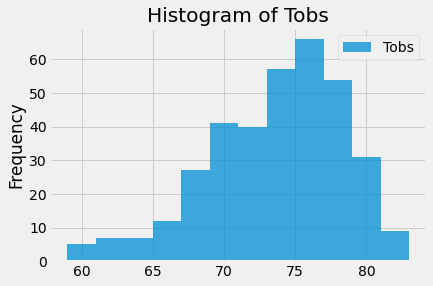

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = dt.datetime.strptime(
              session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).first()[0],
              "%Y-%m-%d")
last_year_date = latest_date - dt.timedelta(days = 365)

results = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
          filter(Measurement.date > last_year_date).all()

x_axis = [row[0] for row in results]

plt.hist(x_axis, bins = 12, label = "Tobs", alpha = 0.75)
plt.title(f"Histogram of Tobs")
plt.ylabel("Frequency")
plt.legend(loc = "best")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [19]:
# Import stats from scipy
from scipy import stats

In [20]:
# Get all tobs in June and in December
jun_results = session.query(Measurement.tobs).filter(extract("month", Measurement.date) == 6).all()
dec_results = session.query(Measurement.tobs).filter(extract("month", Measurement.date) == 12).all()

jun_temp = [row[0] for row in jun_results]
dec_temp = [row[0] for row in dec_results]

# Difference between average temperatures
print(f"Difference between average temperatures: {round((sum(jun_temp) / len(jun_temp) - sum(dec_temp) / len(dec_temp)), 2)}")

Difference between average temperatures: 3.9


In [21]:
# Levene's Test
stats.levene(jun_temp, dec_temp)

# It's lack of homoscedasticity between these two datasets because the p-value is less than 0.05

LeveneResult(statistic=11.486485455366319, pvalue=0.0007094853311953783)

In [22]:
# Welch T-test
t, p = stats.ttest_ind(jun_temp, dec_temp, equal_var = False)

print(f"T Value:{round(t, 2)}")
print(f"P Value:{p}")

T Value:31.36
P Value:4.193529835915755e-187


### Result of Temperature Analysis I

* Difference Average Temperatures between for Jun and for Dec: 3.9
* I skipped a normality test because the number of data is greater than 30.
* I used an unpaired T-test because there's heteroscedasticity between the temperature in June and in December.
* From Welch T-Test, T-Value is 31.36, P-Value is close to 0.
* On the face of it, it looks like seasons don't make much of a difference because the average temperature difference between for Jun and for Dec is only 3.9. However, T-Value and P-Value from the T-test represent there's a statistically significant difference.
* I can say there's a meaningful difference between the temperature in June and in December.

### Temperature Analysis II

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = "2016-01-05"
end_date = "2016-01-31"

tmin, tavg, tmax = calc_temps(start_date, end_date)[0]

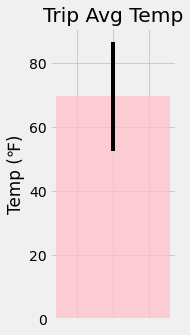

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (2,5))
plt.bar(1, tavg, yerr=(tmax-tmin), color = "pink", alpha=0.75)
# Remove x tick labels
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False
)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (℉)")
plt.show()

### Daily Rainfall Average

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude,\
                       Station.elevation).filter(Station.station == Measurement.station).\
          filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.name).\
          order_by(func.sum(Measurement.prcp).desc()).all()

station_df = pd.DataFrame(results, columns = ["Station", "Total amount of Rainfall", "Name", "Latitude", "Longitude", "Elevation"])

station_df

,Station,Total amount of Rainfall,Name,Latitude,Longitude,Elevation
0,USC00516128,3.45,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.33,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,1.22,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,1.11,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,0.63,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.45,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
days = end_date - start_date

normals = []
trip_dates = []

for i in range(days.days+1):
    date = (start_date + dt.timedelta(days = i)).strftime("%m-%d")
    trip_dates.append(date)
    normals.append(daily_normals(date)[0])

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp_df = pd.DataFrame(normals, columns = ["Min Temperature", "Avg Temperature", "Max Temperature"], index = trip_dates)
trip_temp_df

,Min Temperature,Avg Temperature,Max Temperature
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0
01-10,62.0,69.741379,77.0
01-11,57.0,67.310345,78.0
01-12,57.0,67.407407,81.0
01-13,57.0,67.254545,77.0
01-14,58.0,69.526316,77.0


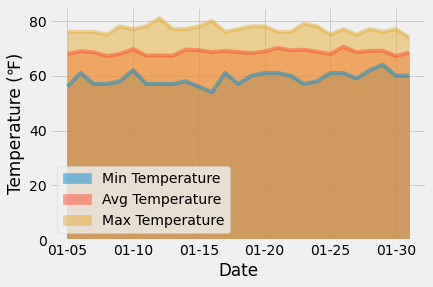

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temp_df.plot.area(stacked = False)
plt.xlabel("Date")
plt.ylabel("Temperature (℉)")
plt.show()